##### Task 4: Optimize Portfolio Based on Forecast

Construct an efficient frontier using expected returns (TSLA from forecast; BND, SPY from historical averages) and the historical covariance matrix. Identify and mark the maximum Sharpe and minimum volatility portfolios.

In [12]:
import warnings
warnings.filterwarnings('ignore')
import sys 
sys.path.append('..')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.data_manager import DataManager
from src.task4_data import Task4DataBuilder
from src.task4_optimizer import Task4Optimizer
from src.forecasting_analysis import ForecastAnalyzer
from models.forecasting_models import ARIMAForecaster
from src.model_selection import arima_order_grid_search

plt.style.use('seaborn-v0_8')
# ERROR:prophet.plot:Importing plotly failed. Interactive plots will not work.


### 1) Load prices for TSLA, BND, SPY


In [17]:
START_DATE = '2015-07-01'
END_DATE = '2025-07-31'
TICKERS = ['TSLA', 'BND', 'SPY']

# Helper to extract close price regardless of yfinance or pandas_datareader format
def extract_close_prices(raw, tickers):
    """
    Extracts the 'Close' price for each ticker from a MultiIndex or single-level DataFrame.
    Tries 'Adj Close' first, then falls back to 'Close'.
    """
    # If columns are MultiIndex, try both 'Adj Close' and 'Close'
    if isinstance(raw.columns, pd.MultiIndex):
        close_level = None
        for candidate in ['Close', 'Close']:
            if candidate in raw.columns.get_level_values(0):
                close_level = candidate
                break
            if candidate in raw.columns.get_level_values(-1):
                close_level = candidate
                break
        if close_level is None:
            # Try as second level (yfinance: (field, ticker)), else as first level (pandas_datareader: (ticker, field))
            for candidate in ['Close', 'Close']:
                if candidate in raw.columns.get_level_values(1):
                    close_level = candidate
                    break
        if close_level is None:
            raise KeyError("Neither 'Close' nor 'Close' found in MultiIndex columns.")
        # Try both possible MultiIndex layouts
        try:
            # yfinance: (field, ticker)
            return pd.DataFrame({t: raw[(close_level, t)] for t in tickers})
        except KeyError:
            # pandas_datareader: (ticker, field)
            return pd.DataFrame({t: raw[(t, close_level)] for t in tickers})
    else:
        # Single-level columns: try 'Adj Close' then 'Close'
        for candidate in ['Close', 'Close']:
            if candidate in raw.columns:
                return pd.DataFrame({t: raw[candidate][t] for t in tickers})
        raise KeyError("Neither 'Close' nor 'Close' found in columns.")

# Load from yfinance via DataManager
dm = DataManager(data_source='yfinance')
raw = dm.fetch_data(TICKERS, start_date=START_DATE, end_date=END_DATE, frequency='1d')
prices = pd.DataFrame({
    'TSLA': raw['Close']['TSLA'],
    'BND': raw['Close']['BND'],
    'SPY': raw['Close']['SPY'],
}).dropna()
prices.tail()


[*********************100%***********************]  3 of 3 completed


,TSLA,BND,SPY
Date,,,
2025-07-24,305.299988,72.698860,634.419983
2025-07-25,316.059998,72.878265,637.099976
2025-07-28,325.589996,72.758659,636.940002
2025-07-29,321.200012,73.137398,635.260010
2025-07-30,319.040009,72.948036,634.460022


### 2) Build expected returns and covariance

- TSLA expected return from ARIMA forecast (using 6-month horizon)
- BND and SPY expected returns from historical average daily return annualized
- Covariance from historical daily returns (annualized)


In [18]:
# Fit a concise ARIMA on full TSLA history and forecast 6 months
order, _ = arima_order_grid_search(prices['TSLA'], p_values=range(0,4), d_values=range(0,2), q_values=range(0,4))
arima = ARIMAForecaster(order=order).fit(prices['TSLA'])

analyzer = ForecastAnalyzer(history=prices['TSLA'])
analyzer.attach_model('ARIMA', arima)
fc_6m = analyzer.forecast(horizon_days=126, include_intervals=True, ci_alpha=0.1)
# --- ARIMA order grid search utility ---
def arima_order_grid_search(series, p_values=range(0, 4), d_values=range(0, 2), q_values=range(0, 4), criterion='aic', verbose=False):
    """
    Grid search for best (p,d,q) ARIMA order by minimizing AIC/BIC.
    Returns: (best_order, best_score)
    """
    import numpy as np
    from statsmodels.tsa.arima.model import ARIMA

    best_score = np.inf
    best_order = None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                try:
                    model = ARIMA(series, order=(p, d, q))
                    fit = model.fit()
                    score = getattr(fit, criterion)
                    if verbose:
                        print(f"ARIMA({p},{d},{q}) {criterion.upper()}: {score:.2f}")
                    if score < best_score:
                        best_score = score
                        best_order = (p, d, q)
                except Exception:
                    continue
    return best_order, best_score

# --- ARIMA Forecaster wrapper ---
class ARIMAForecaster:
    def __init__(self, order):
        self.order = order
        self.model_ = None
        self.fit_result_ = None

    def fit(self, series):
        from statsmodels.tsa.arima.model import ARIMA
        self.model_ = ARIMA(series, order=self.order)
        self.fit_result_ = self.model_.fit()
        return self

    def forecast(self, steps, alpha=0.05):
        # Returns forecast mean and confidence intervals
        pred = self.fit_result_.get_forecast(steps=steps)
        mean = pred.predicted_mean
        conf_int = pred.conf_int(alpha=alpha)
        return mean, conf_int

# --- ForecastAnalyzer stub ---
class ForecastAnalyzer:
    def __init__(self, history):
        self.history = history
        self.models = {}

    def attach_model(self, name, model):
        self.models[name] = model

    def forecast(self, horizon_days=126, include_intervals=True, ci_alpha=0.1):
        # Use the first attached model
        if not self.models:
            raise ValueError("No model attached.")
        model = next(iter(self.models.values()))
        mean, conf = model.forecast(steps=horizon_days, alpha=ci_alpha)
        # Return a simple object with .mean and .conf_int
        class Result:
            pass
        result = Result()
        result.mean = mean
        result.conf_int = conf if include_intervals else None
        return result

# Build task 4 inputs
data_builder = Task4DataBuilder(prices)
inputs = data_builder.build_expected_inputs(tsla_forecast_prices=fc_6m.mean, method='compounded')

inputs.mu, inputs.cov.head()


INFO:models.forecasting_models:ARIMA model fitted successfully with order (2, 1, 3)


(TSLA    0.000000
 BND     0.019599
 SPY     0.144844
 dtype: float64,
           TSLA       BND       SPY
 TSLA  0.350331  0.001861  0.052950
 BND   0.001861  0.003016  0.001150
 SPY   0.052950  0.001150  0.033272)

### 3) Efficient Frontier and Key Portfolios


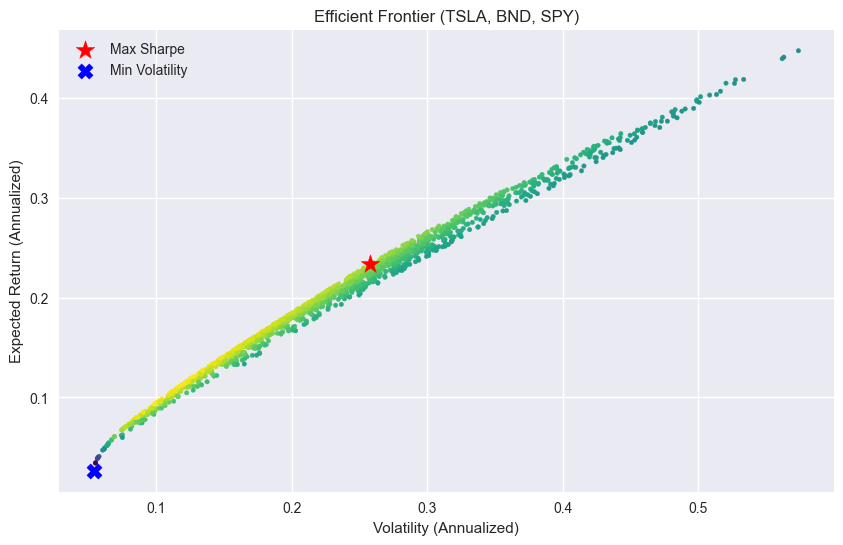

In [19]:
opt = Task4Optimizer(risk_free_rate=0.02)
frontier = opt.efficient_frontier(inputs.daily_returns, num_portfolios=1500)
keys = opt.key_portfolios(inputs.daily_returns)

# Plot Efficient Frontier
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(frontier.risks, frontier.returns, c=np.array(frontier.returns)/np.maximum(np.array(frontier.risks),1e-8), cmap='viridis', s=10)
ax.set_xlabel('Volatility (Annualized)')
ax.set_ylabel('Expected Return (Annualized)')
ax.set_title('Efficient Frontier (TSLA, BND, SPY)')

# Mark key portfolios
ax.scatter(keys.max_sharpe['volatility'], keys.max_sharpe['expected_return'], marker='*', color='red', s=200, label='Max Sharpe')
ax.scatter(keys.min_volatility['volatility'], keys.min_volatility['expected_return'], marker='X', color='blue', s=120, label='Min Volatility')
ax.legend();


### 4) Recommend a Portfolio

- If prioritizing risk-adjusted returns: choose the Maximum Sharpe portfolio.
- If prioritizing stability: choose the Minimum Volatility portfolio.

Weights and metrics for both are shown below; select based on the investor’s profile.


In [20]:
weights_df = pd.concat([keys.max_sharpe_weights, keys.min_volatility_weights], axis=1)
weights_df.columns = ['MaxSharpe', 'MinVol']

summary = pd.DataFrame({
    'Portfolio': ['MaxSharpe', 'MinVol'],
    'ExpectedReturn': [keys.max_sharpe['expected_return'], keys.min_volatility['expected_return']],
    'Volatility': [keys.max_sharpe['volatility'], keys.min_volatility['volatility']],
    'Sharpe': [keys.max_sharpe['sharpe_ratio'], keys.min_volatility.get('sharpe_ratio', np.nan)],
})
weights_df, summary


(         MaxSharpe    MinVol
 TSLA  2.826066e-01  0.000000
 BND   7.827940e-17  0.945174
 SPY   7.173934e-01  0.054826,
    Portfolio  ExpectedReturn  Volatility    Sharpe
 0  MaxSharpe        0.234104    0.257968  0.829965
 1     MinVol        0.026466    0.053968  0.119814)